In [1]:
import sys
# sys.path.append("F:/Vaibhav/M3RG/Work/Benchmarking/Torch_codes/")
# import source.Systems as Systems
# import source.Visualisation as Vis
# from source import Optimizers
import os
from datetime import datetime
import pandas as pd
import torch
import torch
import numpy as np
from joblib import Parallel, delayed
import h5py
from tqdm import tqdm
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')


In [2]:
from bokeh.models import ColumnDataSource, ColorBar, LogColorMapper, LogTicker
from bokeh.plotting import figure, output_file, show
from bokeh.palettes import RdBu as bokeh_palette
from bokeh.sampledata.periodic_table import elements
from bokeh.transform import dodge
from bokeh.io import show as show_
from bokeh.models import ColorBar, LogTicker
from typing import List
import warnings
from csv import reader
import pandas as pd
from pandas import options

def format_number(value: float) -> str:
    """
    Format the number into a readable string with suffixes for large values.
    - 1k for 1000, 1M for 1 million, etc.
    - Keep the number as an integer if it is close to an integer value.
    """
    if value >= 1_000_000:
        return f"{value / 1_000_000:.1f}M" if value % 1_000_000 else f"{int(value / 1_000_000)}M"
    elif value >= 1_000:
        return f"{value / 1_000:.1f}k" if value % 1_000 else f"{int(value / 1_000)}k"
    elif value == int(value):  # If value is already an integer, show it as is
        return str(int(value))
    else:
        return str(value)

def plotter(
    filename: str,
    show: bool = True,
    output_filename: str = None,
    width: int = 1050,
    cmap: str = "viridis",  # Default can still be set to viridis if needed
    alpha: float = 0.65,
    extended: bool = True,
    periods_remove: List[int] = None,
    groups_remove: List[int] = None,
    cbar_height: float = None,
    cbar_standoff: int = 12,
    cbar_fontsize: int = 14,
    blank_color: str = "#c4c4c4",
    special_elements: List[str] = None,
    special_color: str = "#6F3023",
) -> figure:
    """
    Plot a heatmap over the periodic table of elements with log scale and max value capped at second highest.
    Color shades will range from teal to blue.
    """
    options.mode.chained_assignment = None

    # Custom teal to blue palette
    teal_blue_palette = ["#00B2A9", "#0096A9", "#007AA9", "#005EA9", "#0042A9", "#0026A9", "#000AA9"]

    # Define number of and groups
    period_label = ["1", "2", "3", "4", "5", "6", "7"]
    group_range = [str(x) for x in range(1, 19)]

    # Remove any groups or periods
    if groups_remove:
        for gr in groups_remove:
            gr = gr.strip()
            group_range.remove(str(gr))
    if periods_remove:
        for pr in periods_remove:
            pr = pr.strip()
            period_label.remove(str(pr))

    # Read in data from CSV file
    data_elements = []
    data_list = []
    for row in reader(open(filename)):
        data_elements.append(row[0])
        data_list.append(row[1])
    data = [float(i) for i in data_list]

    if len(data) != len(data_elements):
        raise ValueError("Unequal number of atomic elements and data points")

    period_label.append("blank")
    period_label.append("La")
    period_label.append("Ac")

    if extended:
        count = 0
        for i in range(56, 70):
            elements.period[i] = "La"
            elements.group[i] = str(count + 4)
            count += 1

        count = 0
        for i in range(88, 102):
            elements.period[i] = "Ac"
            elements.group[i] = str(count + 4)
            count += 1

    # Get the second maximum value
    sorted_data = sorted(data)
    second_max = sorted_data[-2]
    min_val = min(data)

    # Define log scale with custom color palette
    for datum in data:
        if datum < 0:
            raise ValueError(
                f"Entry for element {datum} is negative but log-scale is selected"
            )
    
    # Modified color mapper to use log scale and cap at second max
    color_mapper = LogColorMapper(
        palette=teal_blue_palette, 
        low=min_val, 
        high=second_max
    )
    
    # Set blank color
    color_list = [blank_color] * len(elements)

    # Prepare a dictionary to hold the values of each element for display
    element_values = {data_elements[i]: data[i] for i in range(len(data_elements))}

    # Compare elements in dataset with elements in periodic table
    for i, data_element in enumerate(data_elements):
        element_entry = elements.symbol[
            elements.symbol.str.lower() == data_element.lower()
        ]
        if element_entry.empty == False:
            element_index = element_entry.index[0]
        else:
            warnings.warn("Invalid chemical symbol: " + data_element)
        if color_list[element_index] != blank_color:
            warnings.warn("Multiple entries for element " + data_element)
        else:
            # Manually map each data point to its color using the log color map
            normed_value = (data[i] - min_val) / (second_max - min_val)  # Normalize value
            
            # Ensure the normalized value is clamped between 0 and 1
            normed_value = max(0, min(1, normed_value))

            # Map the normalized value to the color palette index
            color_list[element_index] = teal_blue_palette[int(normed_value * (len(teal_blue_palette) - 1))]

    if special_elements:
        for k, v in elements["symbol"].iteritems():
            if v in special_elements:
                color_list[k] = special_color

    # Create a list of formatted values for each element (leave blank if not in data)
    value_list = []
    for symbol in elements["symbol"]:
        if symbol in element_values:
            formatted_value = format_number(element_values[symbol])  # Format the number
            value_list.append(formatted_value)
        else:
            value_list.append("")

    # Define figure properties for visualizing data
    source = ColumnDataSource(
        data=dict(
            group=[str(x) for x in elements["group"]],
            period=[str(y) for y in elements["period"]],
            sym=elements["symbol"],
            value=value_list,  # Add the formatted values here
            type_color=color_list,
        )
    )

    # Plot the periodic table
    p = figure(x_range=group_range, y_range=list(reversed(period_label)), tools="save")
    p.width = width
    p.outline_line_color = None
    p.background_fill_color = None
    p.border_fill_color = None
    p.toolbar_location = "above"
    p.rect("group", "period", 0.9, 0.9, source=source, alpha=alpha, color="type_color")
    p.axis.visible = False
    text_props = {
        "source": source,
        "angle": 0,
        "color": "black",
        "text_align": "left",
        "text_baseline": "middle",
    }
    x = dodge("group", -0.4, range=p.x_range)
    y = dodge("period", 0.3, range=p.y_range)
    
    # Use value instead of atomic number for display
    p.text(
        x=x,
        y="period",
        text="sym",
        text_font_style="bold",
        text_font_size="16pt",
        **text_props,
    )
    p.text(x=x, y=y, text="value", text_font_size="11pt", **text_props)

    # Create LogTicker for proper logarithmic scale
    color_bar = ColorBar(
        color_mapper=color_mapper,
        ticker=LogTicker(base=10),  # Use LogTicker instead of BasicTicker
        border_line_color=None,
        label_standoff=cbar_standoff,
        location=(0, 0),
        orientation="vertical",
        scale_alpha=alpha,
        major_label_text_font_size=f"{cbar_fontsize}pt",
        major_label_overrides={second_max: f"{second_max:.2e}+"},  # Add + to the maximum tick
        # title="Frequency",  # Set the title for the color scale
        title_text_font_size="14pt",  # Font size for the title
        title_text_font_style="bold",  # Font style for the title
        title_text_font="Arial",  # Font for the title (optional)
        # title_text_align="center",  # Center-align the title
        # title_standoff=16  # Adjust the distance from the color bar


    )
    

    if cbar_height is not None:
        color_bar.height = cbar_height

    p.add_layout(color_bar, "right")
    p.grid.grid_line_color = None

    if output_filename:
        output_file(output_filename)

    if show:
        show_(p)

    return p


    


In [3]:
plotter('/Volumes/Sajid\'s SSD/element_frequency.csv')

Figure(id='1004', ...)

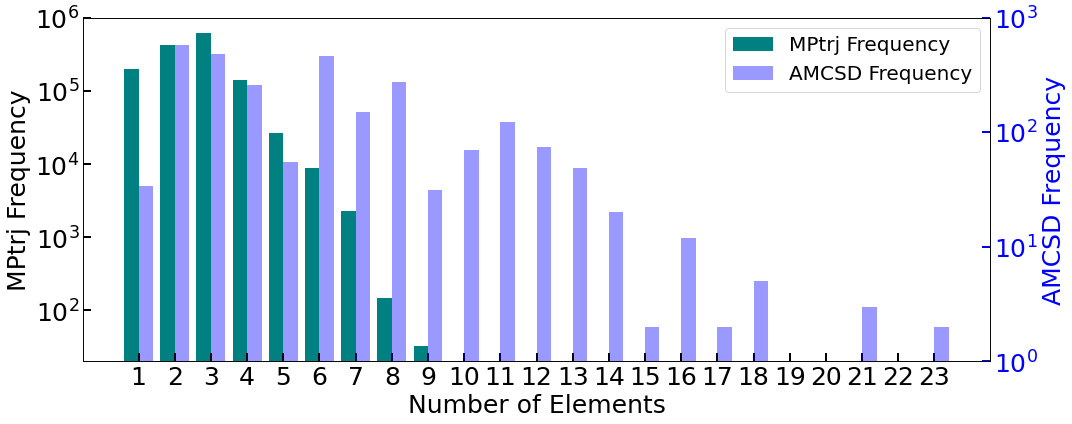

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("/Volumes/Sajid's SSD/category_frequency.csv")
df2 = pd.read_csv("/Volumes/Sajid's SSD/amcsd_mineral_categories.csv")  # Another dataset

# Ensure no NaN values and truncate to 24 entries
df = df.dropna().iloc[:24]
df2 = df2.dropna().iloc[:24]

# Create the figure and the first y-axis
fig, ax1 = plt.subplots(figsize=(15, 6))

# Set the width of the bars
bar_width = 0.4

# Plot the first dataset on the left y-axis
bar1 = ax1.bar(range(1, len(df) + 1), df.iloc[:, 1], color='#008080', label='MPtrj Frequency', width=bar_width)
ax1.set_yscale('log')  # Set y-axis to logarithmic scale
plt.minorticks_off()

# Customize the left y-axis
ax1.set_ylabel('MPtrj Frequency', fontsize=25)  # Updated label
ax1.set_xlabel('Number of Elements', fontsize=25)  # X-axis label
ax1.tick_params(axis='both', direction='in', length=8, width=2, labelsize=25)
ax1.tick_params(axis='y', which='minor', direction='in', length=4, width=1, labelsize=25)

# Create the second y-axis
ax2 = ax1.twinx()

# Plot the second dataset as a bar chart on the right y-axis with a shaded blue effect
bar2 = ax2.bar([x + bar_width for x in range(1, len(df2) + 1)], df2.iloc[:, 1], color='blue', alpha=0.4, label='AMCSD Frequency', width=bar_width)
ax2.set_ylabel('AMCSD Frequency', fontsize=25, color='blue')  # Updated label
ax2.tick_params(axis='y', direction='in', length=8, width=2, labelsize=25, colors='blue')
ax2.set_yscale('log')  # Set y-axis to logarithmic scale
plt.minorticks_off()

# Remove the x-axis ticks and labels from the first axis (ax1)
ax1.set_xticks([])

# Label x-axis ticks only for the second axis, starting from 1 to 24 without repeating
ax2.set_xticks([x + bar_width / 2 for x in range(1, len(df2) + 1)])  # Position the x-ticks in the middle
ax2.set_xticklabels([str(i) for i in range(1, len(df2) + 1)], fontsize=25)  # Set labels from 1 to 24
ax2.set_ylim(1, 1e3)  # Adjust the y-axis limits for the second axis

# Ensure layout is tight and x-axis labels are not clipped
fig.tight_layout()

# Combine legends from both axes into one box at the upper right
plt.legend(handles=[bar1, bar2], labels=['MPtrj Frequency', 'AMCSD Frequency'], loc='upper right', fontsize=20)
plt.savefig('Element_wise_dis_log.png')
# Show the plot
plt.show()


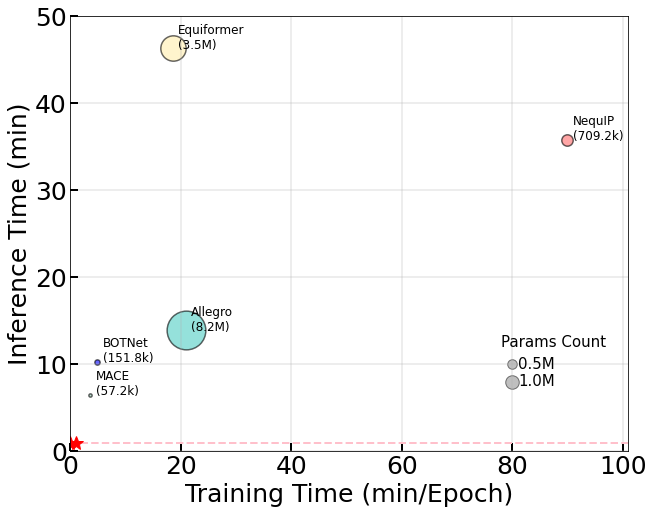

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the plot
models = ['NequIP', 'Allegro', 'BOTNet', 'MACE', 'Equiformer']
training_times = [89.91, 20.89, 4.82, 3.61, 18.51]
inference_times = [35.83, 13.91, 10.29, 6.52, 46.34]
model_params = [709240, 8152968, 151792, 57184, 3496001]

# Convert model_params to millions or thousands
model_params_display = [
    f"{p/1e6:.1f}M" if p >= 1e6 else f"{p/1e3:.1f}k" for p in model_params
]

# Calculate size of circles (normalize parameters to reasonable plot sizes)
sizes = np.array(model_params) / np.max(model_params) * 1500  # Increased base size

# Create color map with more distinct colors
colors = ['#FF6B6B', '#4ECDC4', '#0000FF', '#96CEB4', '#FFEEAD']

# Create the scatter plot with larger figure size
plt.figure(figsize=(10, 8))

# Add grid with higher visibility
plt.grid(True, linestyle='-', alpha=0.3, linewidth=1.5)

# Create scatter plot and annotate points
for i, model in enumerate(models):
    plt.scatter(training_times[i], inference_times[i], s=sizes[i], 
                c=colors[i], alpha=0.6, 
                edgecolor='black', linewidth=1.5)
    # Annotate model name and parameter size near the circle
    plt.text(training_times[i] + 1, inference_times[i], 
             f"{model}\n({model_params_display[i]})", 
             color='black', fontsize=12)

# Add scale bar for circle sizes in bottom right corner
scale_sizes = [5e5, 1e6]  # Example scale values (500k and 1M parameters)
scale_labels = ["0.5M", "1.0M"]
for i, (size, label) in enumerate(zip(scale_sizes, scale_labels)):
    plt.scatter([80], [10 - i * 2], s=size / np.max(model_params) * 1500, 
                c='gray', alpha=0.5, edgecolor='black', linewidth=1)
    plt.text(81, 10 - i * 2, label, fontsize=15, verticalalignment='center', color='black')

plt.text(78, 12, "Params Count", fontsize=15, color='black')

# Customize the plot with larger fonts
plt.xlabel('Training Time (min/Epoch)', fontsize=25)
plt.ylabel('Inference Time (min)', fontsize=25)
# plt.tick_params(axis='both', direction='in', length=8, width=2, labelsize=20)

# Increase tick label size
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlim([0,101])
plt.ylim([0,50])

import matplotlib.pyplot as plt

# Your existing code
plt.tick_params(axis='both', direction='in', length=8, width=2, labelsize=25)

# Adding a red dashed horizontal line at y=9
plt.axhline(y=1, color='pink', linestyle='--', linewidth=2, label='Red Dashed Line')

# Adding a small star line (you can adjust the line size by modifying the marker)
# Adding a small star line (you can adjust the line size by modifying the marker)
plt.plot([0, 1], [1, 1], marker='*', color='red', markersize=15, label='Classical BKS (11)')

# Adding legend with 'Modal Params' for the star
# plt.legend(loc='lower right', title='Modal Params')

# Display the plot
plt.show()
